## Setup and Imports

In [1]:
import math
import keras
import keras_cv
import tensorflow as tf

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

2023-06-20 18:44:08.979264: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-20 18:44:09.485651: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops

## Dataset

In [2]:
# Dataset hyperparameters
IMAGE_SIZE = 96
IMAGE_CHANNELS = 3
NUM_CLASSES = 10

# Algorithm hyperparameters
UNLABELED_BATCH_SIZE = 512
LABELED_BATCH_SIZE = 128
TEST_BATCH_SIZE = 64
WIDTH = 128
TEMPERATURE = 0.1

# Stronger augmentations for contrastive, weaker ones for supervised training
CONTRASTIVE_AUGMENTATION = {
    "min_area": 0.25,
    "brightness": keras_cv.UniformFactorSampler(lower=-0.6, upper=0.6),
    "jitter": keras_cv.UniformFactorSampler(lower=-0.2, upper=0.2),
}
CLASSIFICATION_AUGMENTATION = {
    "min_area": 0.75,
    "brightness": keras_cv.UniformFactorSampler(lower=-0.3, upper=0.3),
    "jitter": keras_cv.UniformFactorSampler(lower=-0.1, upper=0.1),
}

AUTOTUNE = tf.data.AUTOTUNE

In [3]:
def prepare_dataset():
    unlabeled_train_dataset = (
        tfds.load("stl10", data_dir="dataset", split="unlabelled", as_supervised=True)
        .map(lambda image, label: image, num_parallel_calls=AUTOTUNE)
        .shuffle(buffer_size=2 * UNLABELED_BATCH_SIZE)
        .batch(UNLABELED_BATCH_SIZE, num_parallel_calls=AUTOTUNE)
        .prefetch(AUTOTUNE)
    )
    labeled_train_dataset = (
        tfds.load("stl10", data_dir="dataset", split="train", as_supervised=True)
        .shuffle(buffer_size=2 * LABELED_BATCH_SIZE)
        .batch(LABELED_BATCH_SIZE, num_parallel_calls=AUTOTUNE)
        .prefetch(AUTOTUNE)
    )
    test_dataset = (
        tfds.load("stl10", data_dir="dataset", split="test", as_supervised=True)
        .batch(TEST_BATCH_SIZE, num_parallel_calls=AUTOTUNE)
        .prefetch(AUTOTUNE)
    )

    return unlabeled_train_dataset, labeled_train_dataset, test_dataset


# Load STL10 dataset
unlabeled_train_dataset, labeled_train_dataset, test_dataset = prepare_dataset()

2023-06-20 18:45:02.643791: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38169 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


## Augmentation Pipeline

In [4]:
# Distorts the color distibutions of images
class RandomColorAffine(keras_cv.layers.BaseImageAugmentationLayer):
    def __init__(self, brightness, jitter, **kwargs):
        super().__init__(**kwargs)
        self.brightness = brightness
        self.jitter = jitter

    def augment_image(self, image, transformation=None, **kwargs):
        # Same for all colors
        brightness_scales = 1 + self.brightness(shape=(1, 1, 1))

        # Different for all colors
        jitter_matrices = self.jitter(shape=(1, 3, 3))

        color_transforms = (
            tf.eye(num_rows=3) * brightness_scales + jitter_matrices
        )
        image = tf.clip_by_value(tf.matmul(image, color_transforms), 0, 1)

        return image

In [5]:
# Image augmentation module
def get_augmenter(min_area, brightness, jitter):
    zoom_factor = 1.0 - math.sqrt(min_area)
    return keras.Sequential(
        [
            keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)),
            keras_cv.layers.Rescaling(scale=1./255),
            keras_cv.layers.RandomFlip("horizontal"),
            keras_cv.layers.RandomTranslation(
                height_factor=zoom_factor/2,
                width_factor=zoom_factor/2,

            ),
            keras_cv.layers.RandomZoom(
                height_factor=(-zoom_factor, 0.0),
                width_factor=(-zoom_factor, 0.0),
            ),
            RandomColorAffine(brightness, jitter),
        ]
    )

2023-06-20 18:45:09.151204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [16]
	 [[{{node Placeholder/_1}}]]
2023-06-20 18:45:09.151793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [16]
	 [[{{node Placeholder/_0}}]]


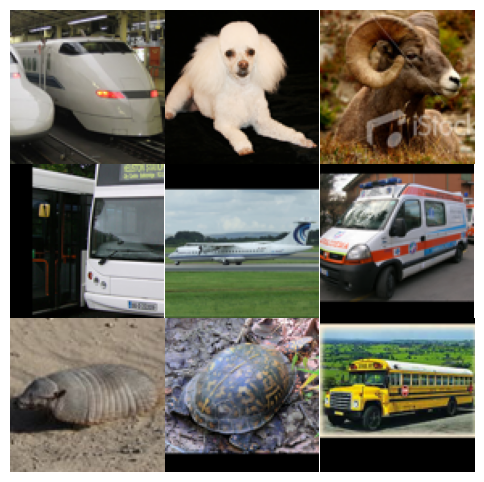

In [6]:
# Original Images
unlabeled_images = next(iter(unlabeled_train_dataset))
keras_cv.visualization.plot_image_gallery(
    images=unlabeled_images,
    value_range=(0, 255),
    rows=3,
    cols=3,
)

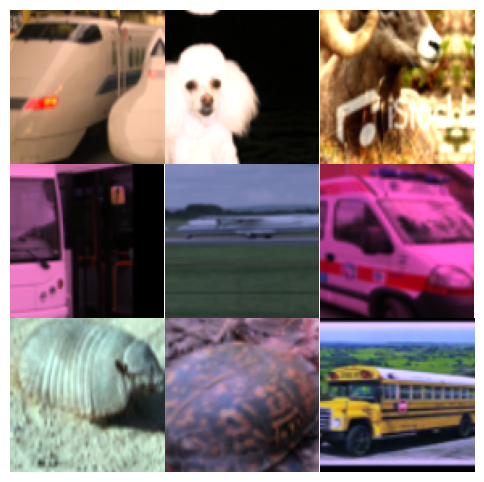

In [7]:
# Contrastive Augmentations
contrastive_augmenter = get_augmenter(**CONTRASTIVE_AUGMENTATION)
augmented_images = contrastive_augmenter(unlabeled_images)
keras_cv.visualization.plot_image_gallery(
    images=augmented_images,
    value_range=(0, 1),
    rows=3,
    cols=3,
)

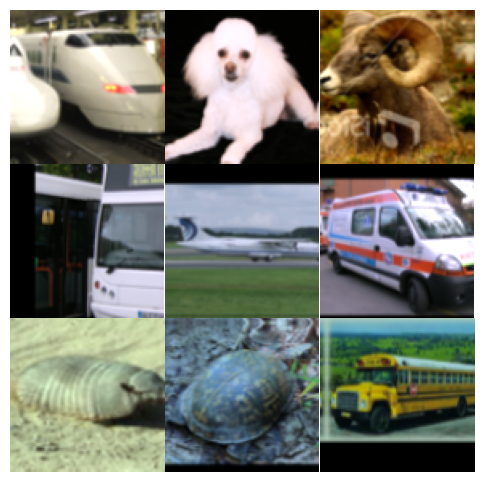

In [8]:
# Classification Augmentations
classification_augmenter = get_augmenter(**CLASSIFICATION_AUGMENTATION)
augmented_images = classification_augmenter(unlabeled_images)
keras_cv.visualization.plot_image_gallery(
    images=augmented_images,
    value_range=(0, 1),
    rows=3,
    cols=3,
)

## Encoder

In [9]:
# Define the encoder architecture
def get_encoder():
    return keras.Sequential([
        keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)),
        keras_cv.models.ResNet18V2Backbone(include_rescaling=False),
        keras.layers.GlobalAveragePooling2D(name="avg_pool"),
    ],
        name="encoder",
)

## Supervised Baseline Model

In [10]:
# Baseline supervised training with random initialization
baseline_model = keras.Sequential(
    [
        keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)),
        get_augmenter(**CLASSIFICATION_AUGMENTATION),
        get_encoder(),
        keras.layers.Dense(10),
    ],
    name="baseline_model",
)
baseline_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

baseline_history = baseline_model.fit(
    labeled_train_dataset, epochs=20, validation_data=test_dataset
)

print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(baseline_history.history["val_acc"]) * 100
    )
)

Epoch 1/20


2023-06-20 18:45:56.270369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2023-06-20 18:45:56.271046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-06-20 18:45:59.926941: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-06-20 18:46:02.703696: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


40/40 [==============================] - ETA: 0s - loss: 2.4221 - acc: 0.1330

2023-06-20 18:46:06.296460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [2]
	 [[{{node Placeholder/_1}}]]
2023-06-20 18:46:06.297089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [2]
	 [[{{node Placeholder/_4}}]]


40/40 [==============================] - 13s 111ms/step - loss: 2.4221 - acc: 0.1330 - val_loss: 2.3516 - val_acc: 0.1000
Epoch 2/20
40/40 [==============================] - 2s 60ms/step - loss: 2.2426 - acc: 0.1996 - val_loss: 2.4884 - val_acc: 0.1000
Epoch 3/20
40/40 [==============================] - 2s 60ms/step - loss: 2.0868 - acc: 0.2494 - val_loss: 2.6445 - val_acc: 0.0999
Epoch 4/20
40/40 [==============================] - 2s 56ms/step - loss: 1.9572 - acc: 0.3048 - val_loss: 2.7864 - val_acc: 0.0996
Epoch 5/20
40/40 [==============================] - 2s 59ms/step - loss: 1.8727 - acc: 0.3208 - val_loss: 2.8538 - val_acc: 0.1035
Epoch 6/20
40/40 [==============================] - 2s 59ms/step - loss: 1.7995 - acc: 0.3432 - val_loss: 2.8938 - val_acc: 0.1251
Epoch 7/20
40/40 [==============================] - 2s 58ms/step - loss: 1.7596 - acc: 0.3532 - val_loss: 2.9050 - val_acc: 0.1419
Epoch 8/20
40/40 [==============================] - 2s 60ms/step - loss: 1.6966 - acc: 0.374

## Self-supervised model for contrastive pretraining

In [11]:
class SimCLRTrainer(keras_cv.training.ContrastiveTrainer):
    def __init__(self, encoder, augmenter, projector, probe=None, **kwargs):
        super().__init__(
            encoder=encoder,
            augmenter=augmenter,
            projector=projector,
            probe=probe,
            **kwargs,
        )

In [12]:
simclr_pre_trainer = SimCLRTrainer(
    encoder=get_encoder(),
    augmenter=get_augmenter(**CONTRASTIVE_AUGMENTATION),
    projector=keras.Sequential(
        [
            keras.layers.Dense(WIDTH, activation="relu"),
            keras.layers.Dense(WIDTH),
            keras.layers.BatchNormalization(),
        ],
        name="projector",
    ),
)

simclr_pre_trainer.compile(
    encoder_optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    encoder_loss=keras_cv.losses.SimCLRLoss(
        temperature=TEMPERATURE,
    ),
)

In [14]:
pretraining_history = simclr_pre_trainer.fit(
    unlabeled_train_dataset,
    epochs=20, # TODO (ariG23498): change this to a higher number of epochs
)

2023-06-20 18:49:20.023136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [16]
	 [[{{node Placeholder/_4}}]]
2023-06-20 18:49:20.023758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_35' with dtype resource
	 [[{{node Placeholder/_35}}]]


Epoch 1/20
196/196 [==============================] - 61s 302ms/step - loss: 12.1268
Epoch 2/20
196/196 [==============================] - 61s 302ms/step - loss: 11.2652
Epoch 3/20
196/196 [==============================] - 61s 302ms/step - loss: 10.6254
Epoch 4/20
196/196 [==============================] - 61s 301ms/step - loss: 10.0917
Epoch 5/20
196/196 [==============================] - 61s 302ms/step - loss: 9.5769
Epoch 6/20
196/196 [==============================] - 61s 302ms/step - loss: 9.1094
Epoch 7/20
196/196 [==============================] - 61s 302ms/step - loss: 8.7020
Epoch 8/20
196/196 [==============================] - 61s 301ms/step - loss: 8.3274
Epoch 9/20
196/196 [==============================] - 62s 308ms/step - loss: 7.9908
Epoch 10/20
196/196 [==============================] - 62s 310ms/step - loss: 7.7212
Epoch 11/20
196/196 [==============================] - 62s 308ms/step - loss: 7.4613
Epoch 12/20
196/196 [==============================] - 61s 304ms/step 

## Fine tuning

In [15]:
simclr_fine_tuner = SimCLRTrainer(
    encoder=simclr_pre_trainer.encoder,
    augmenter=simclr_pre_trainer.augmenters[0],
    projector=simclr_pre_trainer.projectors[0],
    probe=keras_cv.training.ContrastiveTrainer.linear_probe(NUM_CLASSES),
)

simclr_fine_tuner.compile(
    encoder_optimizer=keras.optimizers.Adam(learning_rate=1e-6),
    encoder_loss=keras_cv.losses.SimCLRLoss(
        temperature=TEMPERATURE
    ),
    probe_optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    probe_loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    probe_metrics=[keras.metrics.SparseCategoricalCrossentropy(name="probe_accuracy")]
)

In [16]:
finetuning_history = simclr_fine_tuner.fit(
    labeled_train_dataset,
    epochs=20,
)

2023-06-20 19:09:48.822583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-06-20 19:09:48.823191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]


Epoch 1/20
40/40 [==============================] - 8s 72ms/step - loss: 3.6056 - probe_loss: 265.7277 - probe_accuracy: 11.9085
Epoch 2/20
40/40 [==============================] - 3s 74ms/step - loss: 3.5315 - probe_loss: 238.1048 - probe_accuracy: 10.8373
Epoch 3/20
40/40 [==============================] - 4s 77ms/step - loss: 3.5896 - probe_loss: 212.3864 - probe_accuracy: 9.8494
Epoch 4/20
40/40 [==============================] - 3s 73ms/step - loss: 3.4773 - probe_loss: 187.6318 - probe_accuracy: 8.9770
Epoch 5/20
40/40 [==============================] - 3s 74ms/step - loss: 3.5451 - probe_loss: 165.7087 - probe_accuracy: 8.4972
Epoch 6/20
40/40 [==============================] - 3s 73ms/step - loss: 3.5829 - probe_loss: 147.4513 - probe_accuracy: 8.1203
Epoch 7/20
40/40 [==============================] - 3s 72ms/step - loss: 3.5657 - probe_loss: 137.5759 - probe_accuracy: 7.7639
Epoch 8/20
40/40 [==============================] - 4s 77ms/step - loss: 3.5523 - probe_loss: 125.9779

In [19]:
fine_tuned_model = keras.Sequential([
    keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)),
    simclr_fine_tuner.encoder,
    simclr_fine_tuner.probe,
])


fine_tuned_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)
fine_tuned_model.evaluate(test_dataset)

125/125 [==============================] - 1s 6ms/step - loss: 68.7781 - acc: 0.0799


[68.77814483642578, 0.07987499982118607]